# Fast Growth Prediction of Companies' Profits

### Prediction with Machine Learning -  Assignment 3

### Amirhooshang Navei - CEU, Fall 2023

* Clarification: Many of the data preprocessing techniques and code snippets used in this project were inspired by the book "Data Analysis for Business, Economics, and Policy," and can be found on [the book's GitHub repository.](https://github.com/gabors-data-analysis/da_case_studies/tree/master/ch17-predicting-firm-exit)

* Note: You can access [the latest version of the code](https://github.com/navaei-amir/DA3-phdma/blob/main/HW3/My%20code/HW3.ipynb) through my GitHub repository

In [1]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from plotnine import *
from sklearn.metrics import roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split



### Import Data

In [2]:
df = pd.read_csv(r'C:\Users\PA\Documents\Austria\CEU\3rd Semester\Prediction\Git\DA3-phdma\HW3\Data Cleaning- Prep code\cs_bisnode_panel.csv')

df.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


### Exploring the Data

* Checking the number of years in our dataset

In [3]:
df['year'].unique()

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016], dtype=int64)

* Checking the number of companies in our dataset

In [4]:
df['comp_id'].nunique()


46412

* Checking the number of observations in 2012, 2013 and 2014

In [5]:
df[df['year']==2012].shape, df[df['year']==2013].shape, df[df['year']==2014].shape

((28469, 48), (28474, 48), (28151, 48))

* Keeping the observations within years 2010-2015

In [6]:
df_2 = df[df['year'].isin([2010, 2011, 2012, 2013, 2014, 2015])]

### Dropping the columns with many missing values

In [7]:
df_2.isnull().sum().sort_values(ascending=False)

D                       167606
finished_prod           158855
wages                   158707
COGS                    158556
net_exp_sales           158556
net_dom_sales           158556
exit_year               150648
exit_date               147067
labor_avg                53346
birth_year               43221
founded_year             18409
gender                   18403
inoffice_days            18403
ceo_count                18403
foreign                  18403
origin                   18403
female                   18403
ind                       4966
amort                     4117
personnel_exp             4117
material_exp              4117
extra_profit_loss         3755
extra_inc                 3751
extra_exp                 3751
sales                     3742
inc_bef_tax               3742
region_m                   459
profit_loss_year            67
nace_main                   59
ind2                        59
tang_assets                 57
inventories                 57
curr_lia

* Dropping the columns with many missing values

In [8]:
df_2 = df_2.drop(['D', 'COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages'], axis=1)

### Stacking- Unstacking

* Converting the dataset to panel format and turning the missing values to NaN
* Converting the panel format back to long format

In [9]:
df_2 = (
    df_2.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
df_2 = df_2.replace("toReplace", np.nan)

* Sorting the df_2 by comp_id and year

In [10]:
df_2 = df_2.sort_values(['comp_id', 'year'])

In [11]:
df_2.head()

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,2010,1001034.0,2010-01-01,2010-12-31,177.777771,2096.296387,19629.628906,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333
39375,2011,1001034.0,2011-01-01,2011-12-31,155.555557,3607.407471,22555.554688,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333
78750,2012,1001034.0,2012-01-01,2012-12-31,140.740738,148.148148,21429.628906,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333
118125,2013,1001034.0,2013-01-01,2013-12-31,140.740738,140.740738,21851.851562,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,NaN
157500,2014,1001034.0,2014-01-01,2014-12-31,29.629629,144.444443,22340.740234,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,NaN


### Defining a new variable: profit_growth

In [12]:
df_2['profit_growth'] = df_2['profit_loss_year'].div(df_2['profit_loss_year'].shift(1))-1

In [13]:
df_2.head()

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg,profit_growth
0,2010,1001034.0,2010-01-01,2010-12-31,177.777771,2096.296387,19629.628906,0.0,0.0,0.0,...,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333,NaN
39375,2011,1001034.0,2011-01-01,2011-12-31,155.555557,3607.407471,22555.554688,0.0,0.0,0.0,...,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333,-0.791953
78750,2012,1001034.0,2012-01-01,2012-12-31,140.740738,148.148148,21429.628906,0.0,0.0,0.0,...,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333,0.575472
118125,2013,1001034.0,2013-01-01,2013-12-31,140.740738,140.740738,21851.851562,0.0,0.0,0.0,...,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,NaN,-0.744012
157500,2014,1001034.0,2014-01-01,2014-12-31,29.629629,144.444443,22340.740234,0.0,0.0,0.0,...,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,NaN,-0.292398


* shifting the "profit_growth" by 1 year for easier access

In [14]:
df_2['profit_growth'] = df_2['profit_growth'].shift(-1)

In [15]:
df_2.head()

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg,profit_growth
0,2010,1001034.0,2010-01-01,2010-12-31,177.777771,2096.296387,19629.628906,0.0,0.0,0.0,...,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333,-0.791953
39375,2011,1001034.0,2011-01-01,2011-12-31,155.555557,3607.407471,22555.554688,0.0,0.0,0.0,...,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333,0.575472
78750,2012,1001034.0,2012-01-01,2012-12-31,140.740738,148.148148,21429.628906,0.0,0.0,0.0,...,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333,-0.744012
118125,2013,1001034.0,2013-01-01,2013-12-31,140.740738,140.740738,21851.851562,0.0,0.0,0.0,...,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,NaN,-0.292398
157500,2014,1001034.0,2014-01-01,2014-12-31,29.629629,144.444443,22340.740234,0.0,0.0,0.0,...,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,NaN,0.239669


# Define the binary Target Variable

In [16]:
# defining the target variable: "fast_growth"
df_2['fast_growth'] = np.where((df_2['profit_growth']>0.3) & 
                               (df_2['year']==2012) & 
                               (df_2['profit_loss_year']>0), 1, 0)

In [17]:
df_2.head()

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg,profit_growth,fast_growth
0,2010,1001034.0,2010-01-01,2010-12-31,177.777771,2096.296387,19629.628906,0.0,0.0,0.0,...,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333,-0.791953,0
39375,2011,1001034.0,2011-01-01,2011-12-31,155.555557,3607.407471,22555.554688,0.0,0.0,0.0,...,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333,0.575472,0
78750,2012,1001034.0,2012-01-01,2012-12-31,140.740738,148.148148,21429.628906,0.0,0.0,0.0,...,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333,-0.744012,0
118125,2013,1001034.0,2013-01-01,2013-12-31,140.740738,140.740738,21851.851562,0.0,0.0,0.0,...,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,NaN,-0.292398,0
157500,2014,1001034.0,2014-01-01,2014-12-31,29.629629,144.444443,22340.740234,0.0,0.0,0.0,...,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,NaN,0.239669,0


* Shifting the profit growth back:

In [18]:
df_2['profit_growth'] = df_2['profit_growth'].shift(1)

In [19]:
df_2.head()

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg,profit_growth,fast_growth
0,2010,1001034.0,2010-01-01,2010-12-31,177.777771,2096.296387,19629.628906,0.0,0.0,0.0,...,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333,NaN,0
39375,2011,1001034.0,2011-01-01,2011-12-31,155.555557,3607.407471,22555.554688,0.0,0.0,0.0,...,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333,-0.791953,0
78750,2012,1001034.0,2012-01-01,2012-12-31,140.740738,148.148148,21429.628906,0.0,0.0,0.0,...,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333,0.575472,0
118125,2013,1001034.0,2013-01-01,2013-12-31,140.740738,140.740738,21851.851562,0.0,0.0,0.0,...,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,NaN,-0.744012,0
157500,2014,1001034.0,2014-01-01,2014-12-31,29.629629,144.444443,22340.740234,0.0,0.0,0.0,...,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,NaN,-0.292398,0


* Keeping the observations from 2012

In [20]:
df_2012 = df_2[df_2['year']==2012]

* Dropping the observations with missing values in the "profit_loss_year" variable

In [21]:
df_2012 = df_2012.dropna(subset=['profit_loss_year'])

* checking the stats of "fast_growth" variable

([<matplotlib.axis.XTick at 0x1e4802b8340>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

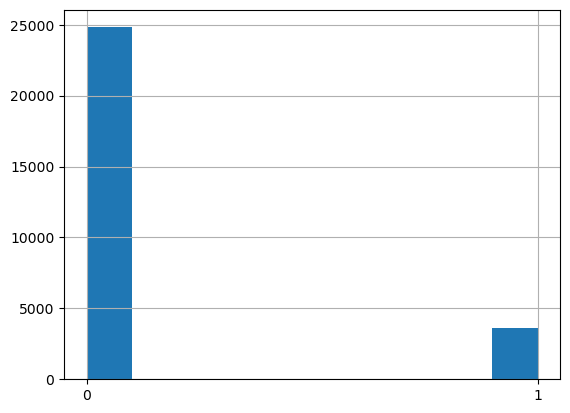

In [22]:
df_2012['fast_growth'].hist()

plt.xticks([0,1])

In [23]:
df_2012['fast_growth'].value_counts(normalize=True)

0    0.872333
1    0.127667
Name: fast_growth, dtype: float64

### Handling the missing values

In [24]:
# checking the missing values in each column
df_2012.isnull().sum()

# sorting the missing values in descending order
df_2012.isnull().sum().sort_values(ascending=False)

exit_year               25052
exit_date               24485
birth_year               7653
labor_avg                7061
profit_growth            3836
founded_year             3184
gender                   3182
inoffice_days            3182
ceo_count                3182
female                   3182
foreign                  3182
origin                   3182
material_exp             1092
personnel_exp            1092
amort                    1092
inc_bef_tax              1023
extra_profit_loss        1023
extra_inc                1023
extra_exp                1023
sales                    1023
ind                       854
region_m                   78
nace_main                   6
ind2                        6
founded_date                3
urban_m                     0
year                        0
balsheet_flag               0
balsheet_notfullyear        0
balsheet_length             0
comp_id                     0
tang_assets                 0
subscribed_cap              0
share_eq  

* Exit Year and Exit Date:

In [25]:
# check if for any observation "exit_year" is smaller than "year"
sum(df_2012['exit_year']<df_2012['year'])

4

In [26]:
# dropping the observations with "exit_year" smaller than "year"
df_2012 = df_2012.drop(df_2012[df_2012['exit_year']<df_2012['year']].index)

In [27]:
# checking the values of the "exit_year" variable
df_2012['exit_year'].value_counts()

2016.0    1407
2015.0    1131
2014.0     489
2013.0     240
2017.0      66
2012.0      60
Name: exit_year, dtype: int64

In [28]:
# dropping the "exit_year" and "exit_date" variables
df_2012 = df_2012.drop(['exit_year', 'exit_date'], axis=1)

* Birth Year:

<Axes: >

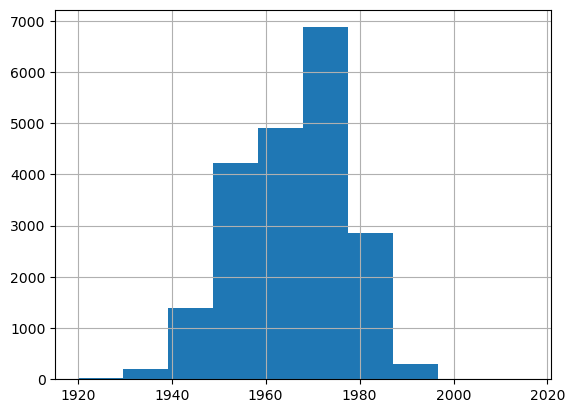

In [29]:
# checking the distribution of "birth_year"
df_2012['birth_year'].hist()

In [30]:
# checking the statistics of "birth_year"
df_2012['birth_year'].describe()

count    20793.000000
mean      1965.760653
std         11.514953
min       1920.000000
25%       1957.000000
50%       1967.000000
75%       1975.000000
max       2016.000000
Name: birth_year, dtype: float64

In [31]:
# adding a flag variable to indicate the missing values
df_2012['birth_year_flag'] = np.where(df_2012['birth_year'].isnull(), 1, 0)

# replacing the missing values in "birth_year" with the median
df_2012['birth_year'] = df_2012['birth_year'].fillna(df_2012['birth_year'].median())

In [32]:
# adding a flag variable to indicate the missing values for "labor_avg"
df_2012['labor_avg_flag'] = np.where(df_2012['labor_avg'].isnull(), 1, 0)

# filling the missing values with the average
df_2012['labor_avg'] = df_2012['labor_avg'].fillna(df_2012['labor_avg'].mean())

* Founded year:

<Axes: >

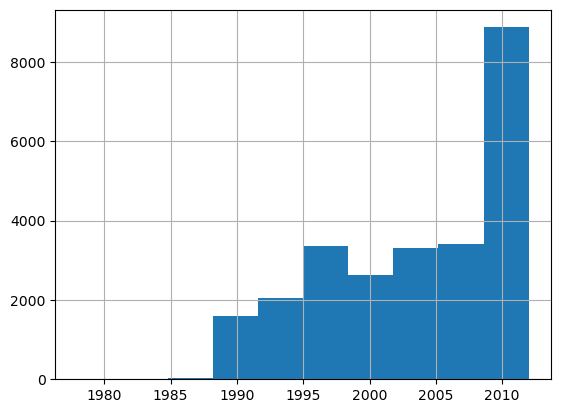

In [33]:
# Checking the distribution of "founded_year"
df_2012['founded_year'].hist()

In [34]:
# checking the statistics of "founded_year"
df_2012['founded_year'].describe()

count    25261.000000
mean      2003.453466
std          6.898892
min       1978.000000
25%       1998.000000
50%       2005.000000
75%       2010.000000
max       2012.000000
Name: founded_year, dtype: float64

In [35]:
# adding a flag variable to indicate the missing values of "founded_year"
df_2012['founded_year_flag'] = np.where(df_2012['founded_year'].isnull(), 1, 0)

# replacing the missing values in "founded_year" with the median
df_2012['founded_year'] = df_2012['founded_year'].fillna(df_2012['founded_year'].median())

* Origin:

<Axes: >

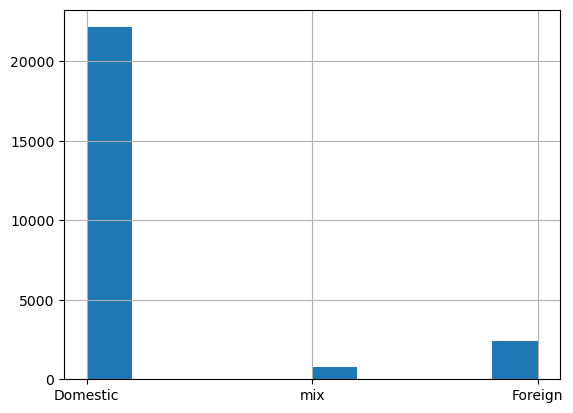

In [36]:
# checking the distribution of "origin"
df_2012['origin'].hist()

In [37]:
# checking the statistics of "origin"
df_2012['origin'].describe()

count        25263
unique           3
top       Domestic
freq         22135
Name: origin, dtype: object

In [38]:
# adding a flag variable to indicate the missing values of "origin"
df_2012['origin_flag'] = np.where(df_2012['origin'].isnull(), 1, 0)

# replacing the missing values in "origin" with the mode and 
df_2012['origin'] = df_2012['origin'].fillna(df_2012['origin'].mode()[0])

* Dropping the observations with missing values in the "profit_growth" variable

In [39]:
df_2012 = df_2012.dropna(subset=['profit_growth'])

In [40]:
df_2012.isnull().sum().sort_values(ascending=False)

foreign                 2020
female                  2020
ceo_count               2020
inoffice_days           2020
gender                  2020
ind                      769
amort                    411
personnel_exp            411
material_exp             411
extra_exp                357
extra_inc                357
extra_profit_loss        357
sales                    357
inc_bef_tax              357
region_m                  67
ind2                       6
nace_main                  6
founded_date               3
labor_avg                  0
urban_m                    0
profit_growth              0
fast_growth                0
origin                     0
birth_year_flag            0
labor_avg_flag             0
birth_year                 0
founded_year_flag          0
year                       0
balsheet_length            0
founded_year               0
inventories                0
begin                      0
end                        0
curr_assets                0
curr_liab     

In [41]:
df_2012.shape

(24610, 46)

* Foreign:

<Axes: >

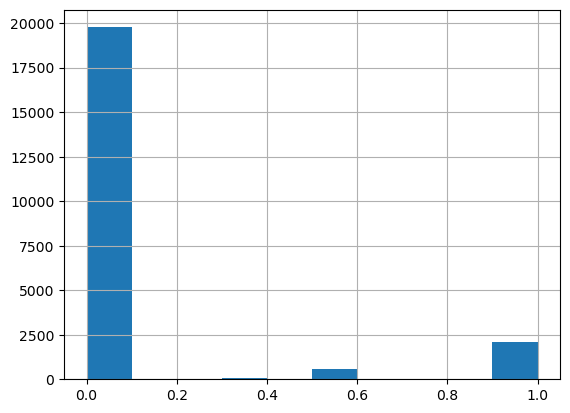

In [42]:
# checking the distribution of "foreign"
df_2012['foreign'].hist()

In [43]:
# create a flag variable to indicate the missing values for "foreign" and fill the missing values with the mode
df_2012['foreign_flag'] = np.where(df_2012['foreign'].isnull(), 1, 0)
df_2012['foreign'] = df_2012['foreign'].fillna(df_2012['foreign'].mode()[0])

* CEO_count:

<Axes: >

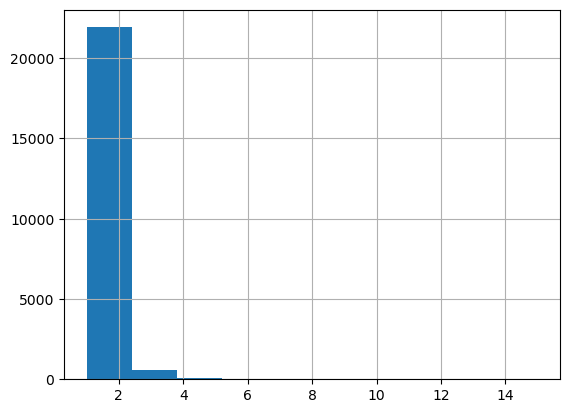

In [44]:
# checking the distribution of "ceo_count"
df_2012['ceo_count'].hist()

In [45]:
# create a flag variable to indicate the missing values for "ceo_count" and fill the missing values with the mode
df_2012['ceo_count_flag'] = np.where(df_2012['ceo_count'].isnull(), 1, 0)
df_2012['ceo_count'] = df_2012['ceo_count'].fillna(df_2012['ceo_count'].mode()[0])

* In office days:

<Axes: >

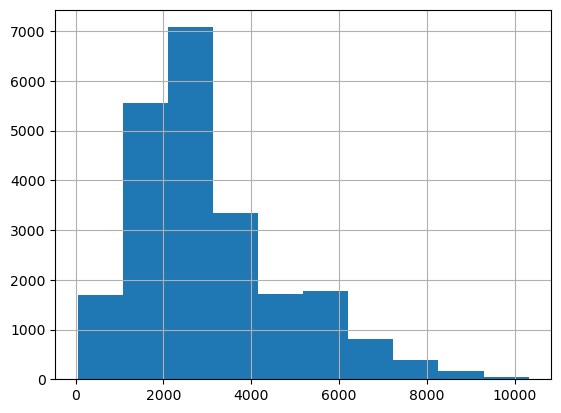

In [46]:
# checking the distribution of "inoffice_days"
df_2012['inoffice_days'].hist()

In [47]:
# create a flag variable to indicate the missing values for "inoffice_days" and fill the missing values with the mean
df_2012['inoffice_days_flag'] = np.where(df_2012['inoffice_days'].isnull(), 1, 0)
df_2012['inoffice_days'] = df_2012['inoffice_days'].fillna(df_2012['inoffice_days'].mean())

* Female:

<Axes: >

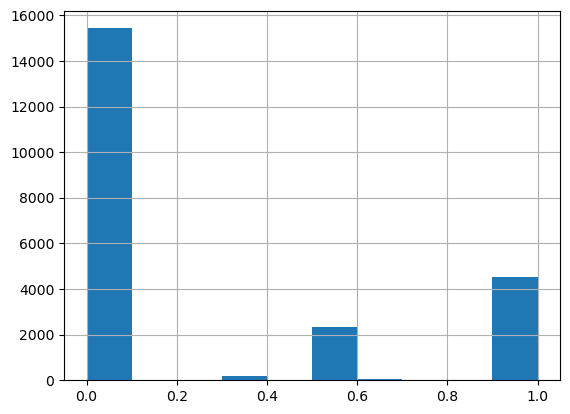

In [48]:
# checking the distribution of "female"
df_2012['female'].hist()

In [49]:
# create a flag variable for missing values of "female" and fill the missing values with the mean
df_2012['female_flag'] = np.where(df_2012['female'].isnull(), 1, 0)
df_2012['female'] = df_2012['female'].fillna(df_2012['female'].mean())

* Gender:

<Axes: >

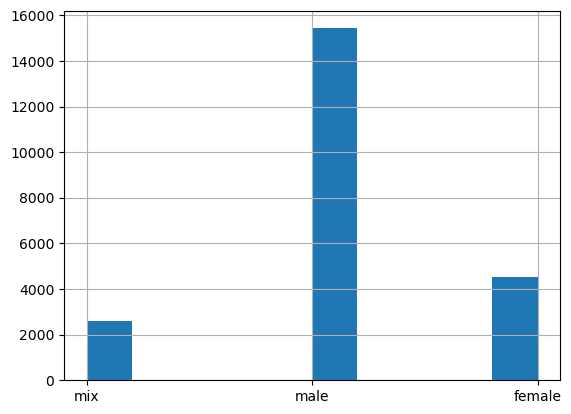

In [50]:
# checking the distribution of "gender"
df_2012['gender'].hist()

In [51]:
# create a flag variable for missing values of "gender"
df_2012["gender_flag"] = np.where(df_2012['gender'].isnull(), 1, 0)

# filling the missing values based on "female"
df_2012.loc[df_2012['female'] == 1, 'gender'] = 'female' 
df_2012.loc[(df_2012['female'] > 0) & (df_2012['female'] < 1), 'gender'] = 'mix' 
df_2012.loc[df_2012['female'] == 0, 'gender'] = 'male'

## Dropping the missing observations

In [52]:
df_2012 = df_2012.dropna(subset=['liq_assets', 'fixed_assets', 'curr_assets', 'inc_bef_tax', 'profit_loss_year', 'tang_assets', 'ind'])

In [53]:
df_2012.isnull().sum().sort_values(ascending=False)

region_m                64
amort                   52
personnel_exp           52
material_exp            52
founded_date             3
year                     0
birth_year               0
inoffice_days            0
gender                   0
origin                   0
nace_main                0
ind2                     0
ind                      0
urban_m                  0
labor_avg                0
foreign                  0
profit_growth            0
fast_growth              0
birth_year_flag          0
labor_avg_flag           0
founded_year_flag        0
origin_flag              0
foreign_flag             0
ceo_count_flag           0
inoffice_days_flag       0
female_flag              0
female                   0
founded_year             0
ceo_count                0
intang_assets            0
begin                    0
end                      0
curr_assets              0
curr_liab                0
extra_exp                0
extra_inc                0
extra_profit_loss        0
f

In [54]:
df_2012.shape

(23498, 51)

In [55]:
# dropping the observations with missing values
df_2012 = df_2012.dropna() 

<Axes: >

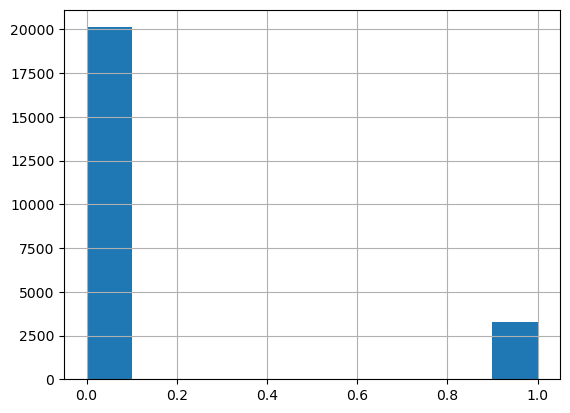

In [56]:
# checking the distribution of "fast_growth"
df_2012['fast_growth'].hist()

### Feature Engineering

* Creating a flag variable for negative values of "sales" and converting the negative values to 0.

In [57]:
df_2012['sales_neg_flag'] = np.where(df_2012['sales']<0, 1, 0)

df_2012['sales'] = df_2012['sales'].mask(df_2012['sales']<0, 1)

* Creating the "Sales in thousands" and "log- Sales in thousands" variables:

c:\Users\PA\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log


<Axes: >

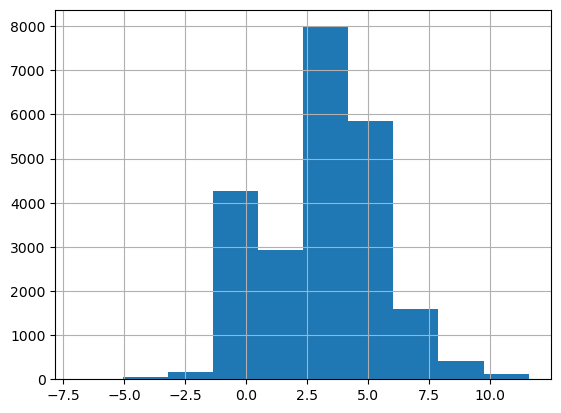

In [58]:
df_2012['sales_thous'] = df_2012['sales'].div(1000)

df_2012['sales_thous_log'] = np.where(df_2012['sales_thous']>0, np.log(df_2012['sales_thous']), 0)

df_2012['sales_thous_log'].hist()

* Defining the "age" of the company and a dummy variable for young firms.

In [59]:
df_2012['age'] = df_2012['year'] - df_2012['founded_year']

df_2012['new'] = np.where(df_2012['age']<=1, 1, 0)

* Dropping the very large or very small companies

In [60]:
df_2012 = df_2012.drop(df_2012[(df_2012['sales']>10000000) | (df_2012['sales']<1000)].index)

In [61]:
df_2012.shape

(19050, 56)

### Defining categories for ind2

In [62]:
df_2012["ind2_cat"] = df_2012["ind2"].copy()
df_2012["ind2_cat"] = np.where(df_2012["ind2"] > 56, 60, df_2012["ind2_cat"])
df_2012["ind2_cat"] = np.where(df_2012["ind2"] < 26, 20, df_2012["ind2_cat"])
df_2012["ind2_cat"] = np.where(
    (df_2012["ind2"] < 55) & (df_2012["ind2"] > 35), 40, df_2012["ind2_cat"]
)
df_2012["ind2_cat"] = np.where(df_2012["ind2"] == 31, 30, df_2012["ind2_cat"])
df_2012["ind2_cat"] = np.where(df_2012["ind2"].isna(), 99, df_2012["ind2_cat"])

In [63]:
df_2012.groupby("ind2_cat").count()["comp_id"]

ind2_cat
26.0      996
27.0      613
28.0     1791
29.0      259
30.0      151
33.0     1704
55.0     2133
56.0    11403
Name: comp_id, dtype: int64

* Adding "Age Squared" to dataset

In [64]:
df_2012["age_sq"] = df_2012["age"] ** 2

* converting the "foreign" variable to a dummy

In [65]:
df_2012["foreign_management"] = np.where(
    df_2012["foreign"] >= 0.5, 1, np.where(df_2012["foreign"].isna(), np.nan, 0)
)

* "flag_asset_problem"

In [66]:
# create a flag variable for negative values of assets
df_2012["flag_asset_problem"] = np.where(
    (df_2012["intang_assets"] < 0)
    | (df_2012["curr_assets"] < 0)
    | (df_2012["fixed_assets"] < 0),
    1,
    0,
)

# Changing the negative values to 0
df_2012["intang_assets"] = np.where(df_2012["intang_assets"] < 0, 0, df_2012["intang_assets"])
df_2012["curr_assets"] = np.where(df_2012["curr_assets"] < 0, 0, df_2012["curr_assets"])
df_2012["fixed_assets"] = np.where(df_2012["fixed_assets"] < 0, 0, df_2012["fixed_assets"])


### Defining the "Total Assets" variable

In [67]:
df_2012["total_assets"] = (
    df_2012["intang_assets"] + df_2012["curr_assets"] + df_2012["fixed_assets"]
)

* Seperating the Profit-Loss and Balance Sheet variables

In [68]:
# profit-loss variables:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]

# balance sheet variables:
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]

* Normalizing the Profit-Loss and Balance sheet variables

In [69]:
# normalizing the profit-loss variables
for i in pl_names:
    df_2012[i + "/sales"] = df_2012[i] / df_2012["sales"]

# normalizing the balance sheet variables
for i in bs_names:
    df_2012[i + "/total_assets"] = df_2012[i] / df_2012["total_assets"]

* Winsorizing, adding the quadratic form of some profit and balance sheet variables.

In [70]:
# list of variables that should be between -1 and 1
var_list = [
    "extra_profit_loss/sales",
    "inc_bef_tax/sales",
    "profit_loss_year/sales",
    "share_eq/total_assets",
]

for i in var_list:
    df_2012[i + "_flag_low"] = np.where(df_2012[i] < -1, 1, 0)

for i in var_list:
    df_2012[i] = np.where(df_2012[i] < -1, -1, df_2012[i])

for i in var_list:
    df_2012[i + "_flag_high"] = np.where(df_2012[i] > 1, 1, 0)

for i in var_list:
    df_2012[i] = np.where(df_2012[i] > 1, 1, df_2012[i])

# adding the quadratic terms of the variables in "var_list"
for i in var_list:
    df_2012[i + "_sq"] = df_2012[i] ** 2

* Creating the "ceo_age" and categorizing into 3 bins.

In [71]:
df_2012["ceo_age"] = df_2012["year"] - df_2012["birth_year"]


df_2012["ceo_age_0_25_flag"] = np.where(df_2012["ceo_age"] <= 25, 1, 0)
df_2012["ceo_age_25_65_flag"] = np.where(
    (df_2012["ceo_age"] > 25) & (df_2012["ceo_age"] <= 65), 1, 0
)
df_2012["ceo_age_65_120_flag"] = np.where(df_2012["ceo_age"] > 65, 1, 0)


df_2012["ceo_age"] = np.where(df_2012["ceo_age"] < 25, 25, df_2012["ceo_age"])
df_2012["ceo_age"] = np.where(df_2012["ceo_age"] > 65, 65, df_2012["ceo_age"])
df_2012["ceo_age"] = np.where(
    (df_2012["ceo_age"] > 25) & (df_2012["ceo_age"] < 65),
    df_2012["ceo_age"].mean(),
    df_2012["ceo_age"],
)

* Adding the quadratic term of "sales_thous_log"

In [72]:
df_2012["sales_thous_log_sq"] = df_2012["sales_thous_log"] ** 2

### Plotting "fast growth" against "Sales Thousands Log"

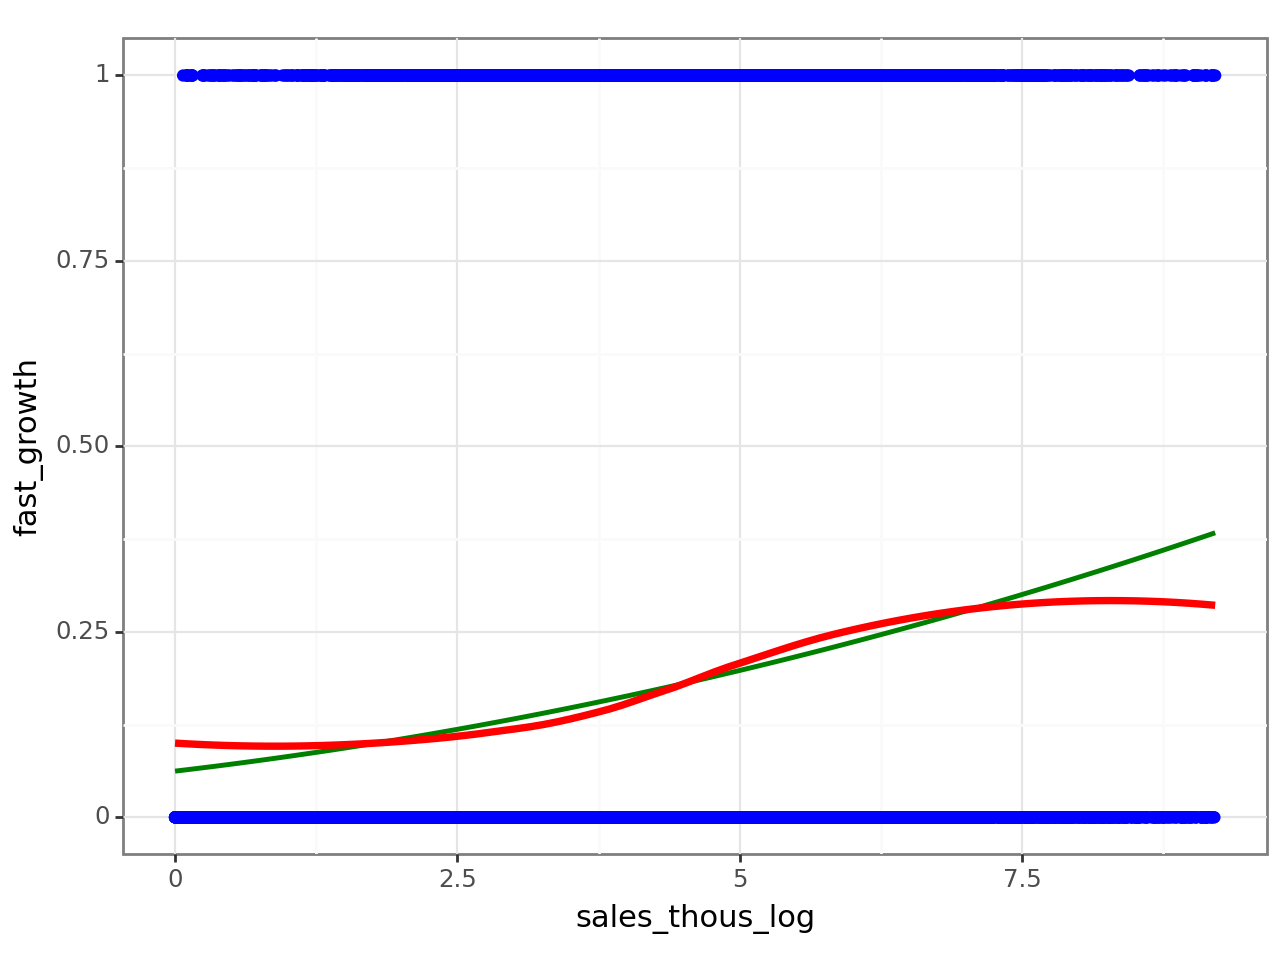

<Figure Size: (640 x 480)>

In [73]:
(
    ggplot(df_2012, aes(x="sales_thous_log", y="fast_growth"))
    + geom_point(color='blue')
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color="green", se=False)
    + geom_smooth(method="loess", color="red", se=False, size=1.5, span=0.9)
    + labs(x="sales_thous_log", y="fast_growth")
    + theme_bw()
)

In [74]:
# checking for non-zero values in the "balsheet_flag" and "balsheet_notfullyear" variable
df_2012['balsheet_flag'].value_counts(), df_2012['balsheet_notfullyear'].value_counts()

(0.0    19017
 1.0       33
 Name: balsheet_flag, dtype: int64,
 0.0    18884
 1.0      166
 Name: balsheet_notfullyear, dtype: int64)

### Dropping the columns that we have extracted their information

In [75]:
# list of columns that should be dropped
drop_cols = ["year", 'comp_id', "begin", "end", 'founded_year', 'foreign', 'ceo_age', 'founded_date', 'nace_main', 'birth_year' ]

df_2012 = df_2012.drop(drop_cols, axis=1)


In [76]:
# checking the types of the variables
df_2012.dtypes

amort                       float64
curr_assets                 float64
curr_liab                   float64
extra_exp                   float64
extra_inc                   float64
                             ...   
share_eq/total_assets_sq    float64
ceo_age_0_25_flag             int32
ceo_age_25_65_flag            int32
ceo_age_65_120_flag           int32
sales_thous_log_sq          float64
Length: 84, dtype: object

### Categorical variables and converting them into dummies

In [77]:
cat_cols = ['gender', 'origin', 'ind', 'urban_m', 'region_m', 'ind2_cat']

df_2012 = pd.get_dummies(df_2012, columns=cat_cols, drop_first=True)

### Dropping the instances with very short financial year

In [78]:
df_2012[df_2012['balsheet_length']<100].shape

(33, 95)

In [79]:
df_2012 = df_2012.drop(df_2012[df_2012['balsheet_length']<100].index)

* Checking for missing values:

In [80]:
df_2012.isnull().sum()

df_2012.isnull().sum().sort_values(ascending=False)

intang_assets/total_assets    53
fixed_assets/total_assets     53
curr_assets/total_assets      53
tang_assets/total_assets      52
liq_assets/total_assets       44
                              ..
labor_avg_flag                 0
birth_year_flag                0
fast_growth                    0
profit_growth                  0
ind2_cat_56.0                  0
Length: 95, dtype: int64

* Dropping the observations with missing values

In [81]:

df_2012 = df_2012.dropna()

* Checking for infinite values in dataset:

In [82]:
df_2012.isin([np.inf, -np.inf]).sum().sum()

629

* Dropping the observations with inf values

In [83]:
df_2012 = df_2012.replace([np.inf, -np.inf], np.nan).dropna()

### Creating a list of flag variables:

In [84]:
flag_list = [i for i in df_2012.columns if ("missing" in i) | ("flag" in i)]

flag_list

['balsheet_flag',
 'birth_year_flag',
 'labor_avg_flag',
 'founded_year_flag',
 'origin_flag',
 'foreign_flag',
 'ceo_count_flag',
 'inoffice_days_flag',
 'female_flag',
 'gender_flag',
 'sales_neg_flag',
 'flag_asset_problem',
 'extra_profit_loss/sales_flag_low',
 'inc_bef_tax/sales_flag_low',
 'profit_loss_year/sales_flag_low',
 'share_eq/total_assets_flag_low',
 'extra_profit_loss/sales_flag_high',
 'inc_bef_tax/sales_flag_high',
 'profit_loss_year/sales_flag_high',
 'share_eq/total_assets_flag_high',
 'ceo_age_0_25_flag',
 'ceo_age_25_65_flag',
 'ceo_age_65_120_flag']

* Dropping the flag variables with no variation

In [85]:
for i in flag_list:
    if df_2012[i].nunique() == 1:
        df_2012 = df_2012.drop(i, axis=1)

* Making a copy of the dataframe.
* We will use this copy to check the performance of the models on manufacturers and service companies.

In [86]:
df_2012_cat = df_2012.copy()
df_2012 = df_2012.drop(['ind2'], axis=1)

### Splitting target variable and the features

In [87]:
y = df_2012['fast_growth']
X = df_2012.drop('fast_growth', axis=1)

### Running a linear regression model on whole data
* R-2: 0.086

In [88]:
import statsmodels.api as sm
X_ols = sm.add_constant(X)
model = sm.OLS(y, X_ols)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:            fast_growth   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     21.51
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          3.79e-291
Time:                        21:02:50   Log-Likelihood:                -7047.6
No. Observations:               18335   AIC:                         1.426e+04
Df Residuals:                   18254   BIC:                         1.489e+04
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

### Running a logistic regression model on whole data
* Pseudo R-2: 0.179

In [89]:
X_ols = sm.add_constant(X)
model = sm.Logit(y, X_ols)
results = model.fit()
print(results.summary())


         Current function value: 0.368618
         Iterations: 35


c:\Users\PA\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


                           Logit Regression Results                           
Dep. Variable:            fast_growth   No. Observations:                18335
Model:                          Logit   Df Residuals:                    18252
Method:                           MLE   Df Model:                           82
Date:                Thu, 14 Dec 2023   Pseudo R-squ.:                  0.1788
Time:                        21:02:51   Log-Likelihood:                -6758.6
converged:                      False   LL-Null:                       -8230.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -3.9408   3.22e+06  -1.22e-06      1.000   -6.31e+06    6.31e+06
amort                              4.494e-07        nan       

* Splitting the data into train and test (holdout) sets

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=123,
                                                    stratify=y)

* Checking the frequency of classes in different sets

In [91]:
y.value_counts(normalize=True), y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(0    0.834361
 1    0.165639
 Name: fast_growth, dtype: float64,
 0    0.834333
 1    0.165667
 Name: fast_growth, dtype: float64,
 0    0.83447
 1    0.16553
 Name: fast_growth, dtype: float64)

* creaiting lists for storing the results

In [92]:
models = []
CV_RMSE = []
CV_AUC = []
Expected_loss= []
Optimal_threshold = []

## Logit Regressions

* Defining the model
* considering 5 folds
* comuting 2 measures for the model: rmse and auc
* Defining a loss function to find the optimal threshold
* implementing the trained model on the holdout set, computing the confusion matrix using the optimal threshold.

In [93]:
# Step 1: Cross-Validated Performance
lr = LogisticRegression(max_iter=5000) 
cv = StratifiedKFold(n_splits=5)

cv_auc_scores = cross_val_score(lr, X_train, y_train, cv=cv, scoring='roc_auc')
cv_rmse_scores = cross_val_score(lr, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_rmse_scores)

print("Average CV AUC:", np.mean(cv_auc_scores))
print("Average CV RMSE:", np.mean(cv_rmse_scores))

# Step 2: Define Loss Function and Compute Optimal Threshold
def custom_loss(y_true, y_pred, fp_cost=4, fn_cost=6):
    fp = np.sum((y_pred == 1) & (y_true == 0)) * fp_cost
    fn = np.sum((y_pred == 0) & (y_true == 1)) * fn_cost
    return fp + fn

lr.fit(X_train, y_train)
probabilities = lr.predict_proba(X_train)[:, 1]

thresholds = np.linspace(0, 1, 100)
losses = []

for threshold in thresholds:
    predictions = (probabilities >= threshold).astype(int)
    loss = custom_loss(y_train, predictions)
    losses.append(loss)

optimal_threshold = thresholds[np.argmin(losses)]
print("Optimal Threshold:", optimal_threshold)

# Step 3: Confusion Table on Test Set
probabilities = lr.predict_proba(X_test)[:, 1]
optimal_predictions = (probabilities >= optimal_threshold).astype(int)
conf_matrix = confusion_matrix(y_test, optimal_predictions)
print("Confusion Matrix:\n", conf_matrix)

Average CV AUC: 0.6043029561077148
Average CV RMSE: 0.41060121359707313
Optimal Threshold: 0.7676767676767677
Confusion Matrix:
 [[3060    0]
 [ 606    1]]


* Computing the Average Expected Loss of Logit model on the holdout set:

In [94]:
# computing the expected loss on the test set
fp_cost = 4
fn_cost = 6
fp = conf_matrix[0, 1] * fp_cost
fn = conf_matrix[1, 0] * fn_cost
expected_loss = (fp + fn) / len(y_test)
print("Expected Loss:", expected_loss)

Expected Loss: 0.9915462230706299


In [95]:
# saving the results in the lists
models.append('Logistic Regression')
CV_AUC.append(np.mean(cv_auc_scores))
CV_RMSE.append(np.mean(cv_rmse_scores))
Expected_loss.append(expected_loss)
Optimal_threshold.append(optimal_threshold)

# Random Forest

* Defining the model
* considering 5 folds
* comuting 2 measures for the model: rmse and auc
* Defining a loss function to find the optimal threshold
* implementing the trained model on the holdout set, computing the confusion matrix using the optimal threshold.

In [96]:
# Step 1: Cross-Validated Performance
rf = RandomForestClassifier()
cv = StratifiedKFold(n_splits=5)

cv_auc_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='roc_auc')
cv_rmse_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_rmse_scores)

print("Average CV AUC:", np.mean(cv_auc_scores))
print("Average CV RMSE:", np.mean(cv_rmse_scores))

# Step 2: Define Loss Function and Compute Optimal Threshold
def custom_loss(y_true, y_pred, fp_cost=4, fn_cost=6):
    fp = np.sum((y_pred == 1) & (y_true == 0)) * fp_cost
    fn = np.sum((y_pred == 0) & (y_true == 1)) * fn_cost
    return fp + fn

rf.fit(X_train, y_train)
probabilities = rf.predict_proba(X_train)[:, 1]

thresholds = np.linspace(0, 1, 100)
losses = []

for threshold in thresholds:
    predictions = (probabilities >= threshold).astype(int)
    loss = custom_loss(y_train, predictions)
    losses.append(loss)

optimal_threshold = thresholds[np.argmin(losses)]
print("Optimal Threshold:", optimal_threshold)

# Step 3: Confusion Table on Test Set
probabilities = rf.predict_proba(X_test)[:, 1]
optimal_predictions = (probabilities >= optimal_threshold).astype(int)
conf_matrix = confusion_matrix(y_test, optimal_predictions)
print("Confusion Matrix:\n", conf_matrix)


Average CV AUC: 0.8489281021391084
Average CV RMSE: 0.4056637945510631
Optimal Threshold: 0.3535353535353536
Confusion Matrix:
 [[2660  400]
 [ 268  339]]


* Computing the Average Expected Loss of RF model on the holdout set:

In [97]:
# computing the expected loss on the test set
fp_cost = 4
fn_cost = 6
fp = conf_matrix[0, 1] * fp_cost
fn = conf_matrix[1, 0] * fn_cost
expected_loss = (fp + fn) / len(y_test)
print("Expected Loss:", expected_loss)

Expected Loss: 0.8748295609490047


In [98]:
# saving the results in the lists
models.append('Random Forest')
CV_AUC.append(np.mean(cv_auc_scores))
CV_RMSE.append(np.mean(cv_rmse_scores))
Expected_loss.append(expected_loss)
Optimal_threshold.append(optimal_threshold)


## GBM

* Defining the model
* considering 5 folds
* comuting 2 measures for the model: rmse and auc
* Defining a loss function to find the optimal threshold
* implementing the trained model on the holdout set, computing the confusion matrix using the optimal threshold.

In [99]:
# Step 1: Cross-Validated Performance
gbm = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=5)

cv_auc_scores = cross_val_score(gbm, X_train, y_train, cv=cv, scoring='roc_auc')
cv_rmse_scores = cross_val_score(gbm, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_rmse_scores)

print("Average CV AUC:", np.mean(cv_auc_scores))
print("Average CV RMSE:", np.mean(cv_rmse_scores))

# Step 2: Define Loss Function and Compute Optimal Threshold
False_Positives = 0
False_Negatives = 0
def custom_loss(y_true, y_pred, fp_cost=4, fn_cost=6):
    fp = np.sum((y_pred == 1) & (y_true == 0)) * fp_cost
    fn = np.sum((y_pred == 0) & (y_true == 1)) * fn_cost
    return fp + fn

gbm.fit(X_train, y_train)
probabilities = gbm.predict_proba(X_train)[:, 1]

thresholds = np.linspace(0, 1, 100)
losses = []

for threshold in thresholds:
    predictions = (probabilities >= threshold).astype(int)
    loss = custom_loss(y_train, predictions)
    losses.append(loss)

optimal_threshold = thresholds[np.argmin(losses)]
print("Optimal Threshold:", optimal_threshold)

# Step 3: Confusion Table on Test Set
probabilities = gbm.predict_proba(X_test)[:, 1]
optimal_predictions = (probabilities >= optimal_threshold).astype(int)
conf_matrix = confusion_matrix(y_test, optimal_predictions)
print("Confusion Matrix:\n", conf_matrix)


Average CV AUC: 0.8573560693018136
Average CV RMSE: 0.39770034693687756
Optimal Threshold: 0.393939393939394
Confusion Matrix:
 [[2815  245]
 [ 365  242]]


### Plotting the optimal threshold for the GBM 

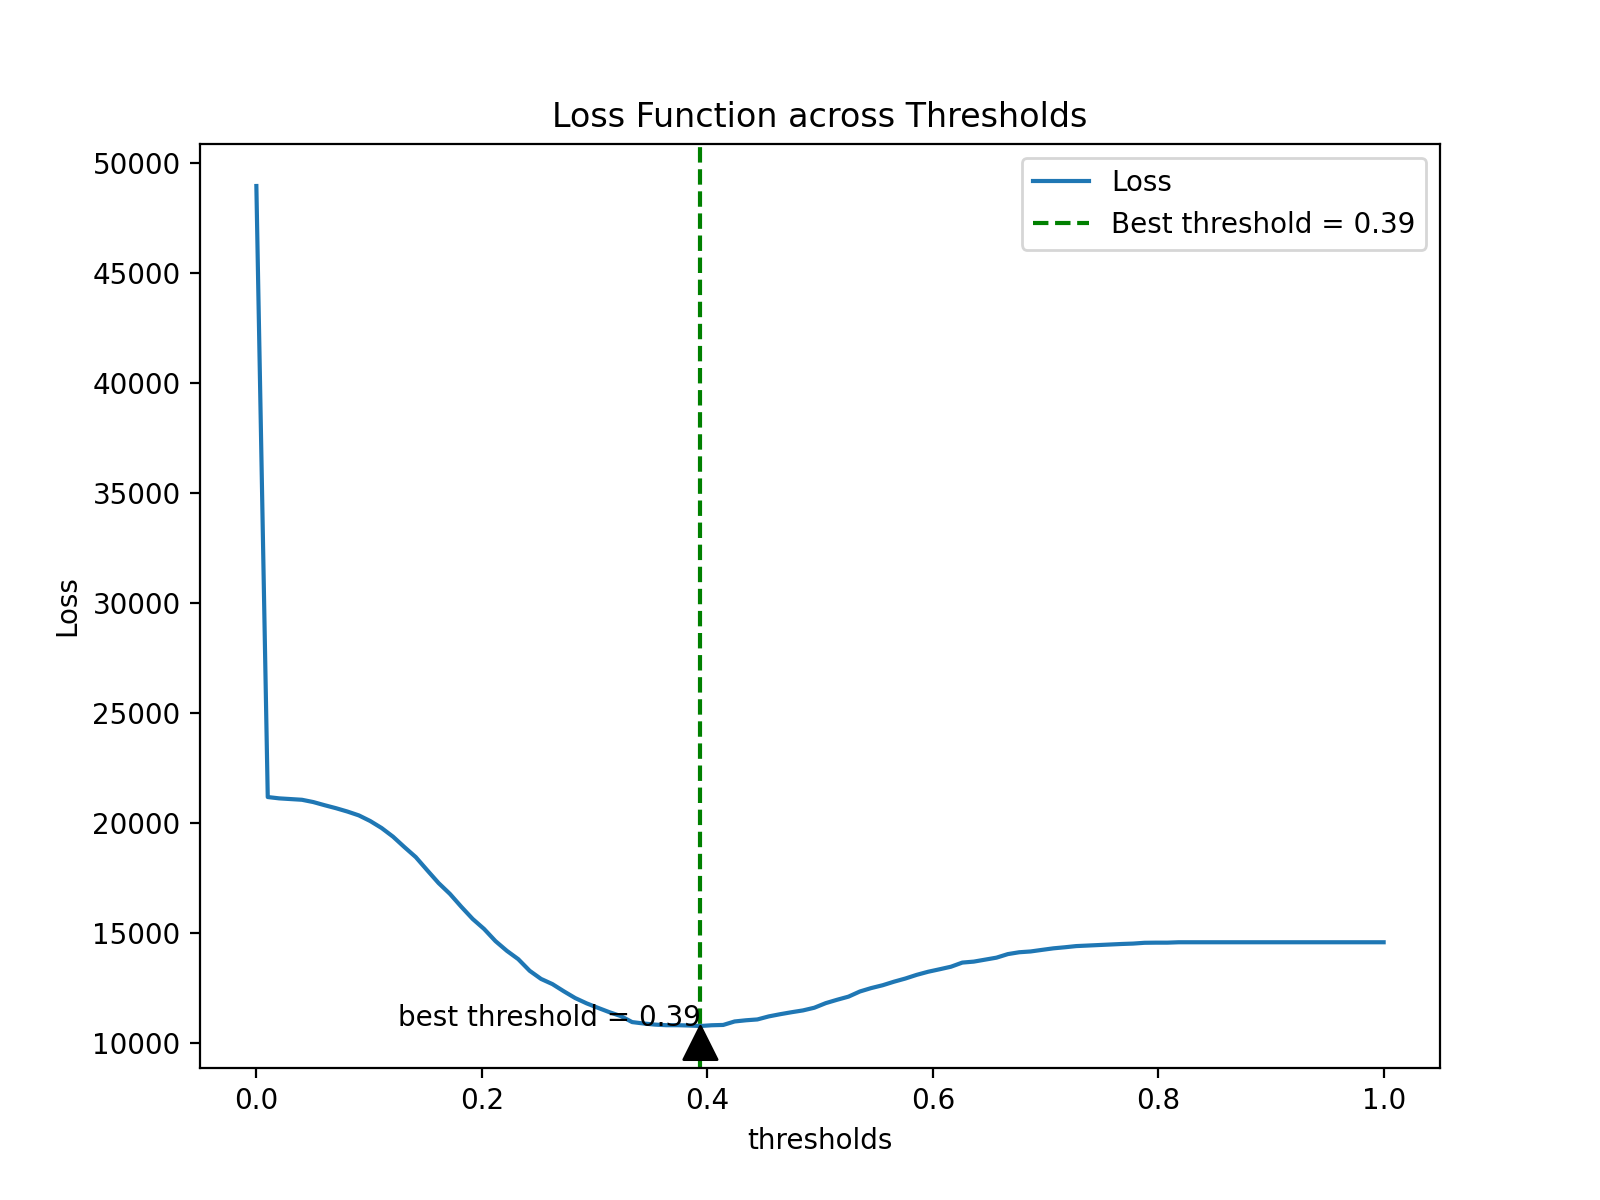

In [100]:
# Plot the loss over different thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, losses, label='Loss')
plt.xlabel('thresholds')
plt.ylabel('Loss')

# Highlight the optimal threshold
plt.axvline(x=optimal_threshold, color='green', linestyle='--', label=f'Best threshold = {optimal_threshold:.2f}')

# Annotate the optimal threshold on the graph
plt.annotate('best threshold = {:.2f}'.format(optimal_threshold),
             xy=(optimal_threshold, min(losses)),
             xytext=(optimal_threshold, min(losses) + 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right')

plt.title('Loss Function across Thresholds')
plt.legend()
plt.show()


### Plotting the ROC curve for GBM model

AUC: 0.86


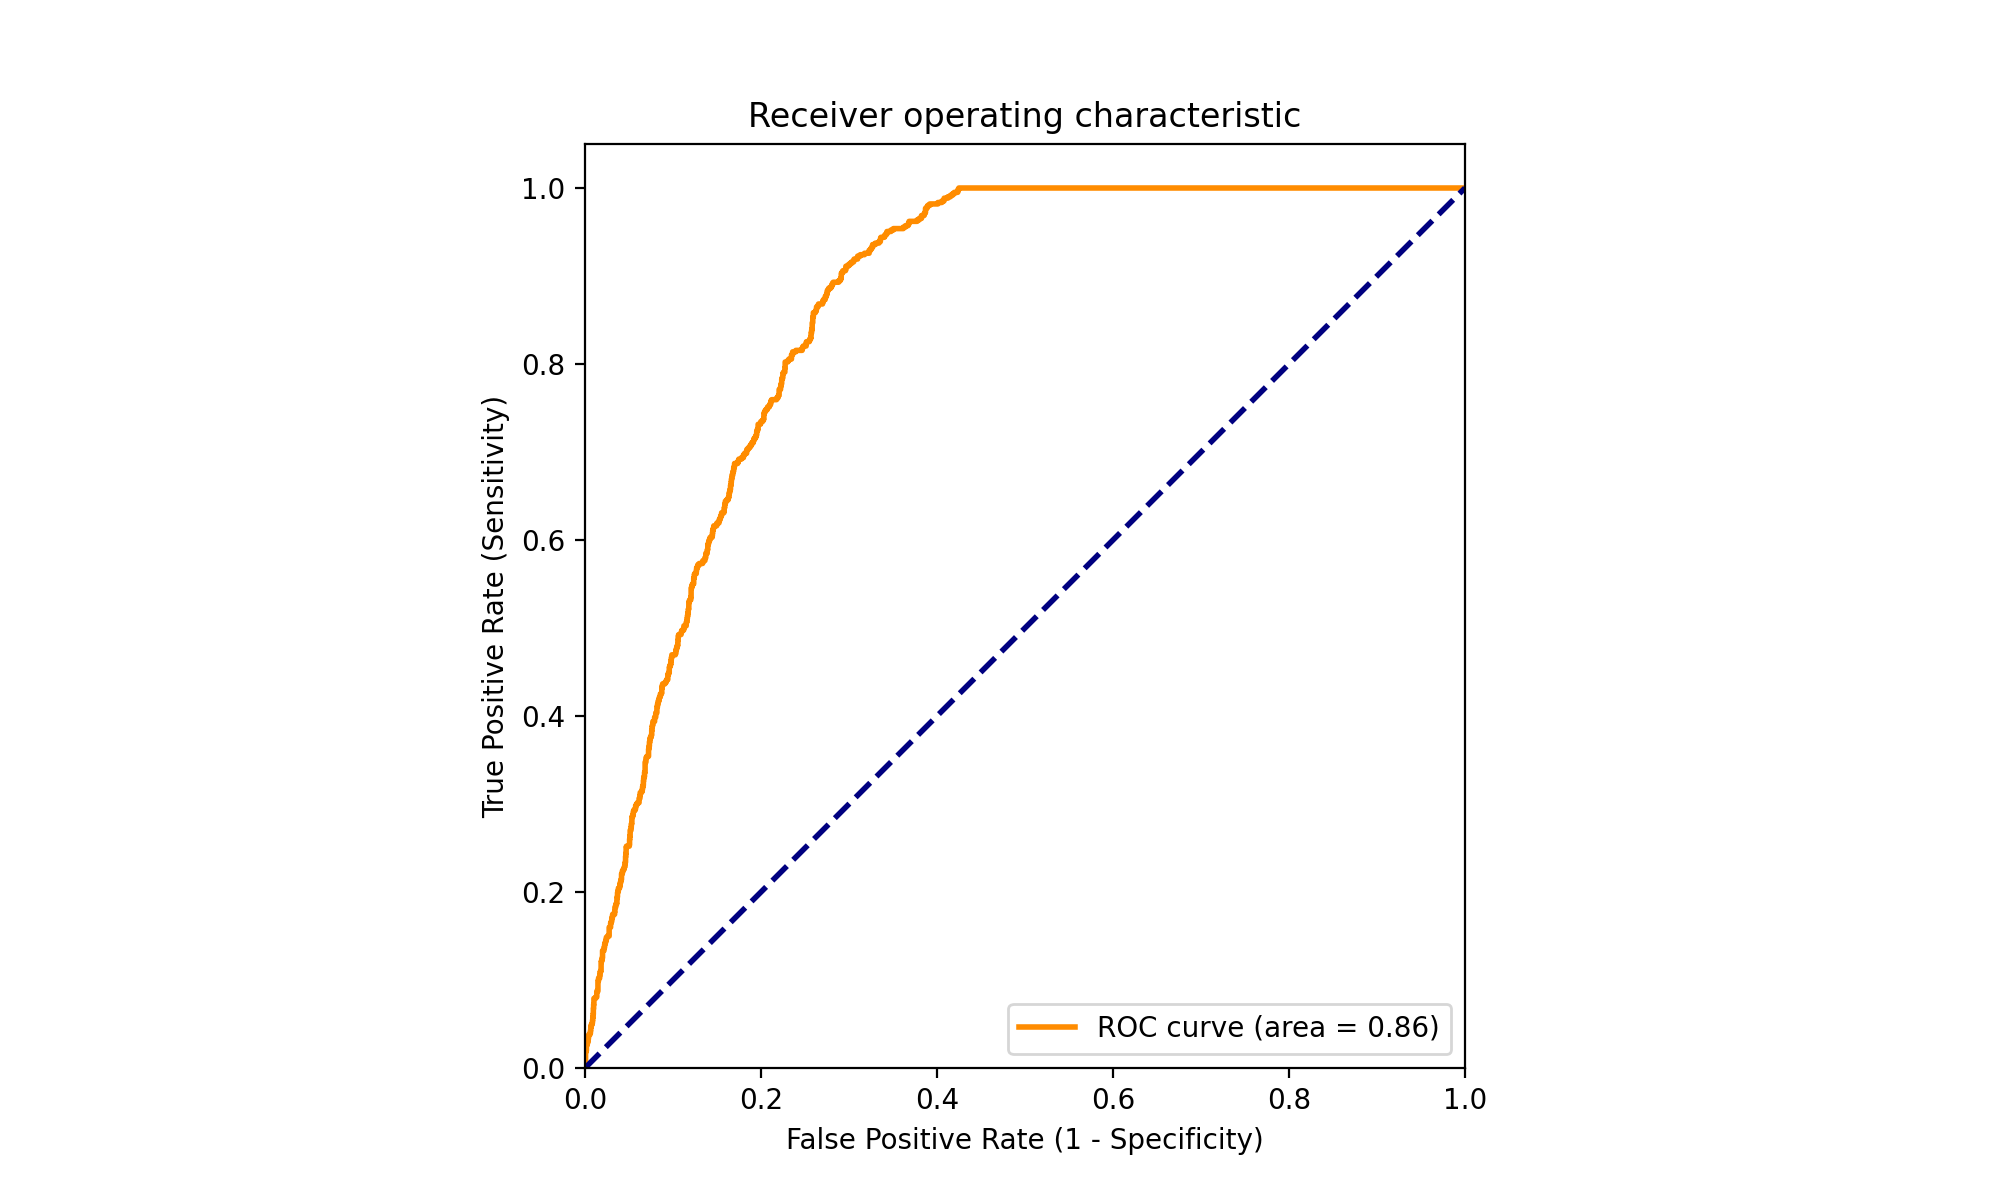

In [101]:
# Fit the model on the training data
gbm.fit(X_train, y_train)

# Predict probabilities for the test set
y_scores = gbm.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the AUC
roc_auc = roc_auc_score(y_test, y_scores)
print("AUC: {:.2f}".format(roc_auc))

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# using the same scale for both axes
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


* Computing the Average Expected Loss of GBM model on the holdout set:

In [102]:
# computing the expected loss on the test set
fp_cost = 4
fn_cost = 6
fp = conf_matrix[0, 1] * fp_cost
fn = conf_matrix[1, 0] * fn_cost
expected_loss = (fp + fn) / len(y_test)
print("Expected Loss:", expected_loss)

Expected Loss: 0.8644668666484865


In [103]:
# saving the results in the lists
models.append('Gradient Boosting')
CV_AUC.append(np.mean(cv_auc_scores))
CV_RMSE.append(np.mean(cv_rmse_scores))
Expected_loss.append(expected_loss)
Optimal_threshold.append(optimal_threshold)

### Comparing the results of 3 models:

In [104]:
# creating a dataframe for the results
results_df = pd.DataFrame({'Model': models, 'CV_AUC': CV_AUC, 'CV_RMSE': CV_RMSE, 
                           'Expected_loss': Expected_loss, 'Optimal_threshold': Optimal_threshold})

pd.options.display.float_format = '{:.3f}'.format
results_df

,Model,CV_AUC,CV_RMSE,Expected_loss,Optimal_threshold
0,Logistic Regression,0.604,0.411,0.992,0.768
1,Random Forest,0.849,0.406,0.875,0.354
2,Gradient Boosting,0.857,0.398,0.864,0.394


In [105]:
# saving the results in a csv file
results_df.to_csv('results.csv', index=False)

## TASK II

* Separating the manufacturing and service companies

In [106]:
# manufacturing companies: ind2<44
df_2012_cat['ind2_manufacturing'] = np.where(df_2012_cat['ind2']<44, 1, 0)

* Storing each section in a separate dataframe

In [107]:
df_2012_cat_manufacturing = df_2012_cat[df_2012_cat['ind2_manufacturing']==1]
df_2012_cat_service = df_2012_cat[df_2012_cat['ind2_manufacturing']==0]

* Dropping the extra columns and missing observations

In [108]:
df_2012_cat_manufacturing = df_2012_cat_manufacturing.drop('ind2_manufacturing', axis=1)
df_2012_cat_service = df_2012_cat_service.drop('ind2_manufacturing', axis=1)

df_2012_cat_manufacturing = df_2012_cat_manufacturing.drop('ind2', axis=1)
df_2012_cat_service = df_2012_cat_service.drop('ind2', axis=1)

df_2012_cat_manufacturing = df_2012_cat_manufacturing.dropna()
df_2012_cat_service = df_2012_cat_service.dropna()

* Separating the target variable from the predictors for both sections

In [109]:
y_manufacturing = df_2012_cat_manufacturing['fast_growth']
X_manufacturing = df_2012_cat_manufacturing.drop('fast_growth', axis=1)

y_service = df_2012_cat_service['fast_growth']
X_service = df_2012_cat_service.drop('fast_growth', axis=1)

In [110]:
X_manufacturing.shape, y_manufacturing.shape, X_service.shape, y_service.shape

((5226, 92), (5226,), (13109, 92), (13109,))

### The performance of RF model on Manufacturing and Service Sectors

### Manufacturing Companies

In [111]:
# Running the trained rf model on the Manufacturing companies
probabilities = rf.predict_proba(X_manufacturing)[:, 1]
optimal_predictions = (probabilities >= 0.333).astype(int)
conf_matrix = confusion_matrix(y_manufacturing, optimal_predictions)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[3803  172]
 [ 100 1151]]


In [112]:
# Computing the expected loss on the manufacturing data
fp_cost = 4
fn_cost = 6
fp = conf_matrix[0, 1] * fp_cost
fn = conf_matrix[1, 0] * fn_cost
expected_loss = (fp + fn) / len(y_manufacturing)
print("Average Loss- Random Forest - Manufacturing:", expected_loss)

Average Loss- Random Forest - Manufacturing: 0.2464600076540375


### Service Companies

In [113]:
# Running the trained rf model on the service companies
probabilities = rf.predict_proba(X_service)[:, 1]
optimal_predictions = (probabilities >= 0.333).astype(int)
conf_matrix = confusion_matrix(y_service, optimal_predictions)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[11036   287]
 [  142  1644]]


In [114]:
# Computing the expected loss on the service data
fp_cost = 4
fn_cost = 6
fp = conf_matrix[0, 1] * fp_cost
fn = conf_matrix[1, 0] * fn_cost
expected_loss = (fp + fn) / len(y_manufacturing)
print("Average Loss- Random Forest - Service:", expected_loss)

Average Loss- Random Forest - Service: 0.3827018752391887


### The performance of GBM model on Manufacturing and Service Sectors

### Manufacturing Companies

In [115]:
# Running the trained gbm model on the manufacturing companies
probabilities = gbm.predict_proba(X_manufacturing)[:, 1]
optimal_predictions = (probabilities >= 0.394).astype(int)
conf_matrix = confusion_matrix(y_manufacturing, optimal_predictions)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[3511  464]
 [ 595  656]]


In [116]:
# computing the expected loss on the manufacturing data
fp_cost = 4
fn_cost = 6
fp = conf_matrix[0, 1] * fp_cost
fn = conf_matrix[1, 0] * fn_cost
expected_loss = (fp + fn) / len(y_manufacturing)
print("Average Loss - GBM - Manufacturing:", expected_loss)

Average Loss - GBM - Manufacturing: 1.0382701875239189


### Service Companies

In [117]:
# running the trained gbm model on the service companies
probabilities = gbm.predict_proba(X_service)[:, 1]
optimal_predictions = (probabilities >= 0.394).astype(int)
conf_matrix = confusion_matrix(y_service, optimal_predictions)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[10722   601]
 [ 1020   766]]


In [118]:
# computing the expected loss on the Service data
fp_cost = 4
fn_cost = 6
fp = conf_matrix[0, 1] * fp_cost
fn = conf_matrix[1, 0] * fn_cost
expected_loss = (fp + fn) / len(y_manufacturing)
print("Average Loss - GBM- Service:", expected_loss)

Average Loss - GBM- Service: 1.631075392269422
